<a href="https://colab.research.google.com/github/suchy1713/expected_goals/blob/master/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
pd.set_option('display.max_columns', 500)
from google.colab import drive

drive.mount('/content/gdrive')
df = pd.read_csv('gdrive/My Drive/events.csv')

#drop everything besides attempts
df = df[df['event_type'] == 1]

#select features I will definitely use
df = df[['location', 'bodypart', 'assist_method', 'situation', 'fast_break', 'is_goal']]

df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,location,bodypart,assist_method,situation,fast_break,is_goal
0,9.0,2.0,1,1.0,0,0
11,15.0,1.0,1,1.0,0,0
13,9.0,2.0,1,1.0,0,1
14,15.0,1.0,0,1.0,0,0
17,15.0,1.0,0,1.0,0,0


Let's deal with missing values:

0


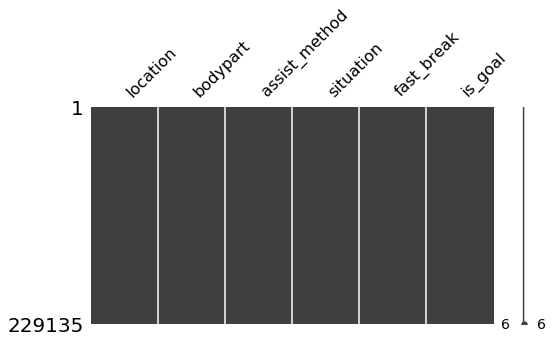

In [32]:
import missingno as mn

mn.matrix(df, figsize=(8, 4))
print(df.isna().sum().sum())

Perfect! But we know that '19' in the location column means 'not recorded'. Let's fix it now.

In [33]:
print((df['location'] == 19).sum())
df = df.drop(df[df['location'] == 19].index)
print((df['location'] == 19).sum())

1450
0


Now let's create new features like range and angle.

In [34]:
def bin_penalty(row):
    if row['location'] == 14:
        return 1
    else:
        return 0

def bin_range(row):
    if row['location'] in [10, 12, 13]:
        return 'short'
    elif row['location'] in [3, 9, 11, 7, 8, 14]:
        return 'medium'
    else:
        return 'long'

def bin_angle(row):
    if row['location'] in [3, 13, 14, 15, 16, 17, 18]:
        return 'easy'
    elif row['location'] in [9, 10, 11, 12]:
        return 'medium'
    else:
        return 'difficult'

def bin_situation(row):
    if row['situation'] == 1:
        return 'open_play'
    else:
        return 'set_piece'

def bin_bodypart(row):
    if (row['bodypart'] == 1 and row['location'] in [5, 8, 11, 12]) or (row['bodypart'] == 2 and row['location'] in [4, 7, 9, 10]):
        return 'further_leg'
    elif (row['bodypart'] == 2 and row['location'] in [5, 8, 11, 12]) or (row['bodypart'] == 1 and row['location'] in [4, 7, 9, 10]):
        return 'closer_leg'
    elif row['bodypart'] == 3:
        return 'head'
    else:
        return 'other'

df['is_penalty'] = df.apply(bin_penalty, axis=1)
df['range'] = df.apply(bin_range, axis=1)
df['angle'] = df.apply(bin_angle, axis=1)
df['situation'] = df.apply(bin_situation, axis=1)
df['bodypart'] = df.apply(bin_bodypart, axis=1)

df = df.drop('location', axis=1)

df.head()

,bodypart,assist_method,situation,fast_break,is_goal,is_penalty,range,angle
0,further_leg,1,open_play,0,0,0,medium,medium
11,other,1,open_play,0,0,0,long,easy
13,further_leg,1,open_play,0,1,0,medium,medium
14,other,0,open_play,0,0,0,long,easy
17,other,0,open_play,0,0,0,long,easy


Now onto the categorical variables. Firstly, for the sake of explainability, I will replace numbers with words.**bold text**

In [35]:
assist_methods = {0: 'none',
                  1: 'pass',
                  2: 'cross',
                  3: 'header',
                  4: 'through_ball'}

df['assist_method'] = list(map(assist_methods.get, df['assist_method']))

df.head()

,bodypart,assist_method,situation,fast_break,is_goal,is_penalty,range,angle
0,further_leg,pass,open_play,0,0,0,medium,medium
11,other,pass,open_play,0,0,0,long,easy
13,further_leg,pass,open_play,0,1,0,medium,medium
14,other,none,open_play,0,0,0,long,easy
17,other,none,open_play,0,0,0,long,easy


Great! So now we can finally encode them.

In [36]:
#encode
df = pd.get_dummies(df, columns=['bodypart', 'assist_method', 'situation', 'range', 'angle'], drop_first=False)

df.head()

,fast_break,is_goal,is_penalty,bodypart_closer_leg,bodypart_further_leg,bodypart_head,bodypart_other,assist_method_cross,assist_method_header,assist_method_none,assist_method_pass,assist_method_through_ball,situation_open_play,situation_set_piece,range_long,range_medium,range_short,angle_difficult,angle_easy,angle_medium
0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1
11,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0
13,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1
14,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0
17,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0


For the last step, let's plot the correlation map.

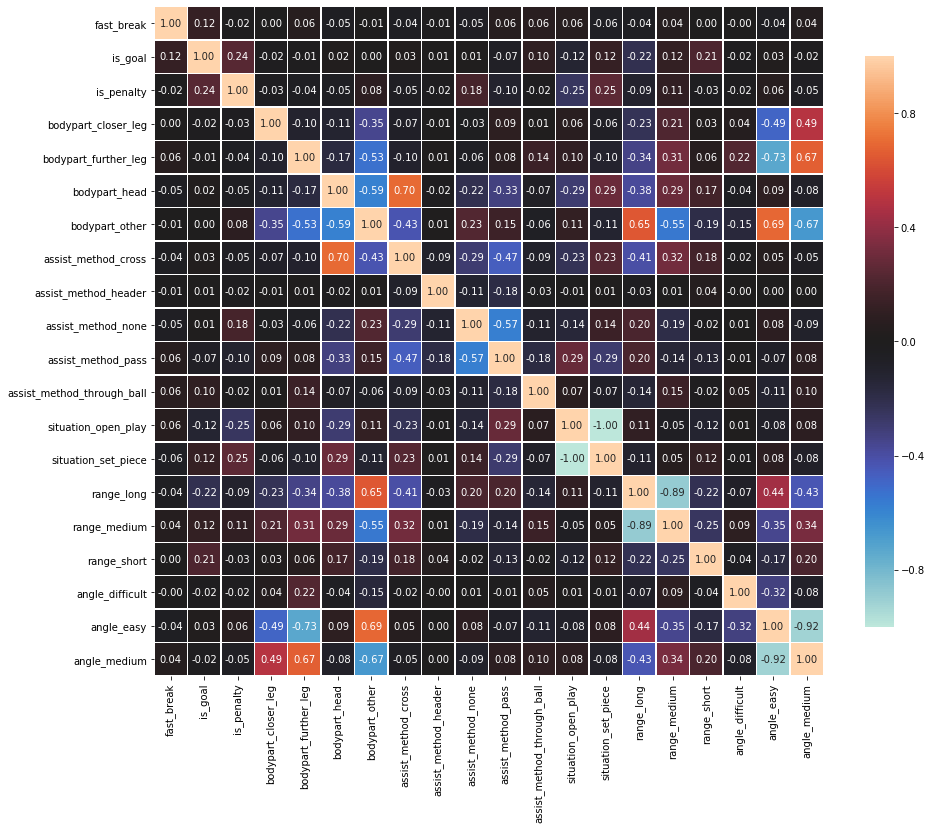

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df.corr(), vmax=1.0, center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();

We've encoutered some strong correlations. Let's drop affected features.

In [0]:
df = df.drop(['situation_set_piece'], axis=1)

In [0]:
df = df.sample(frac=1)
df.to_csv('data.csv', index=False)